# Practice Exercises Week 5 - Language Evolution

This notebook implements a simple version of the language evolution procedure we saw in Week 3, in the papers: 

Steels, Luc, and Martin Loetzsch. "The grounded naming game." Experiments in cultural language evolution 3 (2012): 41-59.

Eyre, Henrietta, and Jonathan Lawry. "Language games with vague categories and negations." Adaptive Behavior 22.5 (2014): 289-303.

In [33]:
import numpy as np
import random
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
import requests
import sklearn
from sklearn import datasets

np.random.seed(0)
random.seed(0)

## Generating data

In [34]:
# This code gives a toy dataset for you to use in running the code for the first time. 
prototypes = np.array([[7, 8],[7.5, 7],[9, 4.5],[4, 2], [6, 2]])
stdevs = np.array([1, 0.3, 0.7, 0.8, 0.7, 0.7])
k = len(prototypes)
data = {}
for i in range(k):
    pts = np.random.multivariate_normal(prototypes[i], (stdevs[i]**2)*np.eye(2), 50)
    data[i] = np.array(pts)

flat_data = np.array([point for key in data for point in data[key]])

Below, add code to import your own dataset

In [35]:
# Import dataset here
import_data = sklearn.datasets.load_wine(return_X_y=False)
wine_dataset = import_data['data']
colour = [row[9] for row in wine_dataset]
hue = [row[10] for row in wine_dataset]

wine_set = np.array([colour,hue]).T

## Agents
Each agent consists of a list of concepts. The concepts are each specified by one prototypical point, and any other parameters that may be needed.

In [36]:
# Set up agents.
# Agents have the prototypes of their concepts and any other parameters that are needed.
num_agents = 4
num_concepts = 2
dim = 2
agents = {i: None for i in range(num_agents)}
for a in agents:
    agents[a] = list(zip(np.random.rand(num_concepts, dim)*5, [1 for i in range(num_concepts)]))

## Membership function

In [37]:
# This function implements the membership function
def mu(c, point,stdev):
    prototype = c[0]
    decay_parameter = c[1]
    dist = np.linalg.norm(prototype-point)
    m = np.exp(-decay_parameter*dist)
    return m    

In [38]:
# Implement your modified membership function here
def mu2(c, point, st):
    prototype = c[0]
    k = st*2
    d = np.linalg.norm(prototype-point)
    #filter out (negative)values
    if 0 <= d <= k:
        return (1-(d/k))
    else:
        return 0

## Naming points
The speaker agent names the point it is shown

In [39]:
# This function takes an agent and a datapoint, and returns a label, which is what the agent thinks is the most 
# appropriate label for the point.
def name_point(agent, point, stdev):
    max_mu = 0
    label = -1
    for i, c in enumerate(agent):
        if mu(c, point, stdev) > max_mu:
            label = i
            max_mu = mu(c, point, stdev)
    return label

## Updating concepts
The listener agent updates its concepts based on the label that the speaker agent asserts.

In [40]:
# This function takes an agent, a label, a point, and some extra parameters, and updates the agent's concepts
def update_concepts(agent, label, point, h, lims):
    new_agent = agent
    mus = []
    prototype = agent[label][0]
    decay_parameter = agent[label][1] * (1+h**3)
    prototype = (1 - h)*prototype + h*point
    for i in range(len(lims)):
        if prototype[i] < lims[i][0]:
            prototype[i] = lims[i][0]
        elif prototype[i] > lims[i][1]:
            prototype[i] = lims[i][1]
    new_agent[label] = (prototype, decay_parameter)
    return new_agent

## Play one iteration of the game
This function randomly selects a pair of agents and a point, and plays the game.

In [41]:
# This function runs one iteration of the game. We choose a speaker and a listener and a point from the dataset.
# The speaker names the point, and then the listener updates its concepts.
def play_game(agent_array, dataset, h, lims, stdevs):
    s, l = random.sample(list(agent_array), 2)
    speaker = agent_array[s]
    listener = agent_array[l]
    stdev = stdevs[s]
    point = random.choice(dataset)
    label = name_point(speaker, point , stdev)
    new_listener = update_concepts(listener, label, point, h, lims)
    agent_array[l] = new_listener
    return agent_array

## Metrics
APD measures the distance between prototypes for the same labels across pairs of agents.

ALO measures the overlap between labels for each agent and then takes the average.

In [42]:
# Calculates the average pairwise distance between agents
def calculate_APD(agent_array):
    dists = []
    agent_pairs = itertools.combinations(agent_array, 2)
    for (p1, p2) in agent_pairs:
        a1 = agent_array[p1]
        a2 = agent_array[p2]
        for i in range(len(a1)):
            pdist = np.linalg.norm(a1[i][0]- a2[i][0])
            dists.append(pdist)
    apd = np.mean(dists)
    return apd

In [43]:
# Calculates average label overlap
def calculate_ALO(agent_array, dataset, stdevs):
    overlap = []
    count = 0
    for agent in agent_array:
        stdev = stdevs[count]
        concept_pairs = itertools.combinations(agent_array[agent], 2)
        for (c1, c2) in concept_pairs:
            max_overlap = 0
            for point in dataset:
                if min(mu(c1, point, stdev), mu(c2, point, stdev)) > max_overlap:
                    max_overlap = min(mu(c1, point, stdev), mu(c2, point, stdev))
            overlap.append(max_overlap)
        count+=1
    alo = np.mean(overlap)
    return alo       

In [44]:
# Run the simulation
def run_sim(agent_array, dataset, num_its, h,  lims, stdevs):
    new_array = copy.deepcopy(agent_array)
    apd_scores = []
    alo_scores = []
    for i in range(num_its):
        new_array = play_game(new_array, dataset, h, lims, stdevs)
        if i % 10 == 0:
            apd_scores.append(calculate_APD(new_array))
            alo_scores.append(calculate_ALO(new_array, dataset,stdevs))
    return new_array, apd_scores, alo_scores

In [45]:
# Run simulation with only 2 concepts
new_agents, apd_sc, alo_sc = run_sim(agents, wine_set,2000, 0.1, [[0, 10], [0, 10]], stdevs)

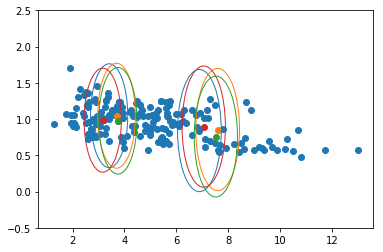

In [46]:
fig, ax = plt.subplots()
x, y = wine_set.T
plt.scatter(x, y)
cols = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
for i, a in enumerate(new_agents):
    ptypes= []
    stdevs=[]
    for c in new_agents[a]:
        ptypes.append(c[0])
        stdevs.append(c[1])
    ptypes = np.array(ptypes)
    x, y = ptypes.T
    plt.scatter(x, y, color = cols[i])
    for j,s in enumerate(stdevs):
        # Draws circles at one standard deviation from the prototype, which is 1/decay_parameter for the exponential distribution
        patch = patches.Circle(ptypes[j], radius=1/s, edgecolor=cols[i],facecolor='none')
        ax.add_patch(patch)
    axes = plt.gca()
    axes.set_ylim([-0.5,2.5])

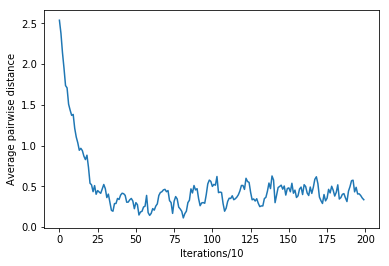

In [47]:
plt.plot(apd_sc)
plt.xlabel("Iterations/10")
plt.ylabel("Average pairwise distance")
plt.show()

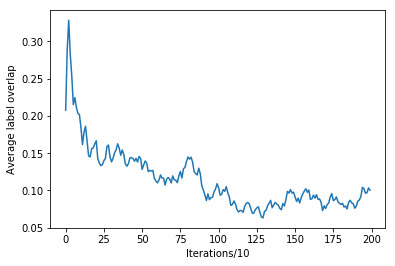

In [48]:
plt.plot(alo_sc)
plt.xlabel("Iterations/10")
plt.ylabel("Average label overlap")
plt.show()

In [49]:
# create centroids for the new concepts
c1 = (new_agents[0][0][0] + new_agents[1][0][0] + new_agents[2][0][0] + new_agents[3][0][0])/4
c2 = (new_agents[0][1][0] + new_agents[1][1][0] + new_agents[2][1][0] + new_agents[3][1][0])/4
centroids = np.array([c1,c2])

In [50]:
# initialize empty lists and dict
concept1 = []
concept2 = []
data = {}

# assign every points to its most similar concept
for point in wine_set:
    currentmem = 0
    currentconcept = 0
    best_c = 0
    for concept in centroids:
        mem = mu([concept,1],point,0)
        if mem > currentmem:
            currentmem = mem
            best_c = currentconcept
        currentconcept+=1
    if best_c == 0:
        concept1.append(point)
    else:
        concept2.append(point)

data[0] = np.array(concept1)
data[1] = np.array(concept2)

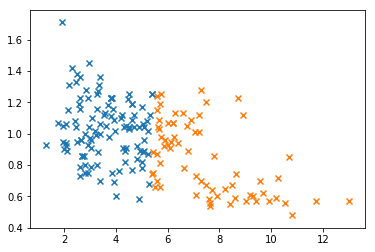

In [51]:
fig2, ax2 = plt.subplots()
for key in data:
    # plt.scatter(")" takes a list of x values and a list of y values, 
    # so we assign the transpose of the datapoints to the tuple (x, y)
    (x, y) = data[key].T
    plt.scatter(x, y, marker = 'x')

In [52]:
# the intersection between two concepts is the min value
def memberIntersection(val1,val2):
    return min(val1,val2)

In [53]:
# initialize dict and list
memvalcombine = []
pointmemval = {}

# for every point in concept 1
for point in data[0]:
    #1. calculate the similarity/membership with concept 1
    val1 = mu([centroids[0],1],point,0)
    #2. calculate the similarity/membership with concept 3
    val2 = mu([centroids[1],1],point,0)
    #3. calculate the similarity/membership with combined concepts and store the result
    memvalcombine.append(memberIntersection(val1,val2))
    pointmemval[tuple(point)] = memberIntersection(val1,val2)
    
# for every point in concept 3    
for point in data[1]:
    #1. calculate the similarity/membership with concept 1
    val1 = mu([centroids[0],1],point,0)
    #2. calculate the similarity/membership with concept 3
    val2 = mu([centroids[1],1],point,0)
    memvalcombine.append(memberIntersection(val1,val2))
    #3. calculate the similarity/membership with combined concepts and store the result
    pointmemval[tuple(point)] = memberIntersection(val1,val2)

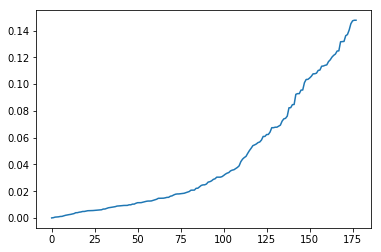

In [54]:
# 1. initialize a figure and an axis
fig3, ax3 = plt.subplots()
# 2. Set up a for loop to iterate over the keys of the dictionary.
sortedlist = sorted(memvalcombine)
plt.plot(sortedlist)

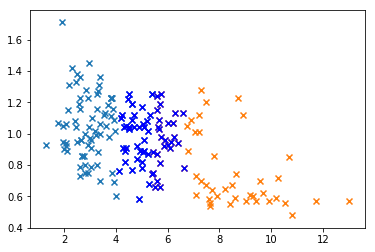

In [55]:
# initialze empty list  
filteredlist = []

# filter out the points below the threshhold
for point in pointmemval:
    if pointmemval[point] > 0.04:
        filteredlist.append(np.array(point))
    
# plot the filtered points
for point in filteredlist:
    (x,y) = point
    ax2.scatter(x, y, marker = 'x', color = 'b')
fig2

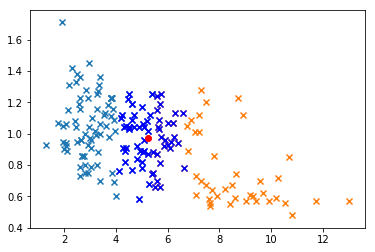

In [56]:
(xN, yN) = np.sum(filteredlist, axis = 0)
centroid = [xN/len(filteredlist), yN/len(filteredlist)]

# plot the new centroid/prototype
ax2.plot(centroid[0],centroid[1], marker = 'o', color = 'r')
fig2

In [57]:
# calculate the average membership value
memvalnewcentroid = 0
for point in filteredlist:
    memvalnewcentroid += mu([centroid,1],point,0)
    
print('The average membership value in the new combined concept is: ' +str(memvalnewcentroid/len(filteredlist)))
print('The average membership value in the intersection is: '+str(sum(memvalcombine)/len(memvalcombine)))

The average membership value in the new combined concept is: 0.5855260723055828
The average membership value in the intersection is: 0.044062891284397616


In [58]:
# Run the language game but this time the agents have to create 3 different concepts

# Set up agents.
# Agents have the prototypes of their concepts and any other parameters that are needed.
num_agents = 4
num_concepts = 3
dim = 2
agents = {i: None for i in range(num_agents)}
for a in agents:
    agents[a] = list(zip(np.random.rand(num_concepts, dim)*5, [1 for i in range(num_concepts)]))

stdevs = np.array([1, 0.3, 0.7, 0.8, 0.7, 0.7])

In [59]:
new_agents, apd_sc, alo_sc = run_sim(agents, wine_set,2000, 0.1, [[0, 10], [0, 10]], stdevs)

In [60]:
# create centroids for the new concepts
c11 = (new_agents[0][0][0] + new_agents[1][0][0] + new_agents[2][0][0] + new_agents[3][0][0])/4
c22 = (new_agents[0][1][0] + new_agents[1][1][0] + new_agents[2][1][0] + new_agents[3][1][0])/4
c33 = (new_agents[0][2][0] + new_agents[1][2][0] + new_agents[2][2][0] + new_agents[3][2][0])/4
centroids = np.array([c11,c22,c33])

In [61]:
# initialize empty arrays and dict
concept1 = []
concept2 = []
concept3 = []
data2 = {}

# for eacht point find its most similar concept
for point in wine_set:
    currentmem = 0
    currentconcept = 0
    best_c = 0
    for concept in centroids:
        mem = mu([concept,1],point,0)
        if mem > currentmem:
            currentmem = mem
            best_c = currentconcept
        currentconcept+=1
    if best_c == 0:
        concept1.append(point)
    elif best_c == 1:
        concept2.append(point)
    else: 
        concept3.append(point)

# store points in the dict
data2[0] = np.array(concept1)
data2[1] = np.array(concept2)
data2[2] = np.array(concept3)

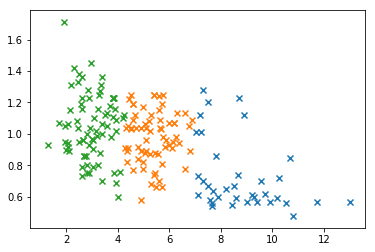

In [62]:
 #plot the data
fig4, ax4 = plt.subplots()
for key in data2:
    # plt.scatter(")" takes a list of x values and a list of y values, 
    # so we assign the transpose of the datapoints to the tuple (x, y)
    (x, y) = data2[key].T
    plt.scatter(x, y, marker = 'x')

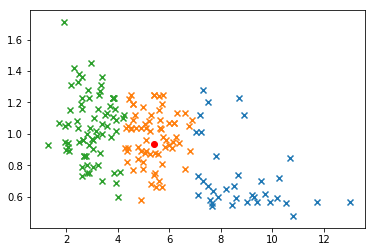

In [63]:
# plot prototype
(x,y) = centroids[1]
ax4.plot(x,y, marker = 'o', color = 'r')
fig4

In [64]:
# calculate the similarity between the concepts
print('The similarity between the concepts is : '+str(mu([centroids[1],1], centroid,0)))

The similarity between the concepts is : 0.8216655028653562
